In [1]:
import os
import time
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


torch.Size([1, 32, 32])


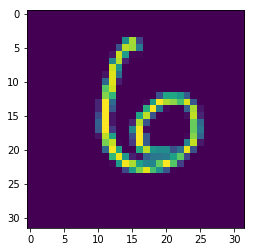

32 100


In [2]:
if not os.path.exists('./previews'):
    os.makedirs('./previews')
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
n_dim = 32
n_feature = 100
n_ch = 1
g_feature_map_b = 64
d_feature_map_b = 64
'''
fold_dataset = datasets.ImageFolder('./pixiv_face_tagged', 
                       transform=transforms.Compose([
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomAffine(5, translate=(0.05,0.05), scale=(0.9,1.1), shear=2, resample=2, fillcolor=tuple([127]*n_ch)),
                           transforms.Resize([n_dim]*2, interpolation=2),
                           transforms.ToTensor(), # normalize to [0,1]
                           transforms.Normalize([0.5]*n_ch, [0.5]*n_ch) # [0,1] -> [-1,+1]
                       ]))
'''
fold_dataset = datasets.MNIST('./mnist_data', download=True, train=False, transform=transforms.Compose([
                           transforms.Pad(2), # 28 -> 32
                           transforms.ToTensor(), # normalize to [0,1]
                           transforms.Normalize([0.5]*n_ch, [0.5]*n_ch) # [0,1] -> [-1,+1]
                       ]))

print(fold_dataset.__getitem__(100)[0].shape)
plt.imshow(np.squeeze(np.clip(np.array(fold_dataset.__getitem__(100)[0]).transpose(1,2,0)*127.5+127.5,0,255).astype(np.uint8)))
plt.show()
data_loader = torch.utils.data.DataLoader(
        fold_dataset,
        batch_size=batch_size, shuffle=True, num_workers=4)
print(n_dim, n_feature)
def inf_data_gen():
    while True:
        for data, label in data_loader:
            yield data
gen = inf_data_gen()

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight.data)

def one_hot(ids, n_class):
    if len(ids.size())==2:
        return ids
    ohe = torch.FloatTensor(ids.size(0), n_class)
    ids = ids.view(-1,1)
    ohe.zero_()
    ohe.scatter_(1, ids, 1)
    return ohe

class ConvolutioBlock(nn.Module):
    def __init__(self, in_ch, out_ch, norm=True, down=False, relu=True, leaky=False, dropout=False):
        super(ConvolutioBlock, self).__init__()
        
        conv_block = []
        conv_block += [nn.Conv2d(in_ch, out_ch, 3, stride=2 if down else 1, padding=1, bias=False)]
        if norm:
            conv_block += [nn.InstanceNorm2d(out_ch)]
        if relu:
            conv_block += [ nn.LeakyReLU(0.2, inplace=True) if leaky else nn.ReLU(inplace=True) ]
        if dropout:
            conv_block += [nn.Dropout(0.05)]

        self.conv_block = nn.Sequential(*conv_block)
        self.conv_block.apply(weights_init)
    def forward(self, x):
        return self.conv_block(x)

# ref SRResNet
class ResidualBlock(nn.Module):
    def __init__(self, in_ch):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1, bias=False),
                        nn.InstanceNorm2d(in_ch),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1, bias=False),
                        nn.InstanceNorm2d(in_ch)  
                     ]

        self.conv_block = nn.Sequential(*conv_block)
        self.conv_block.apply(weights_init)

    def forward(self, x):
        return x + self.conv_block(x)

class UpConvolution(nn.Module):
    def __init__(self, in_ch, out_ch, norm=True, relu=True):
        super(UpConvolution, self).__init__()
        
        conv_block = [nn.PixelShuffle(2)]
        conv_block += [nn.Conv2d(in_ch//4, out_ch, 3, stride=1, padding=1, bias=False)]
        if norm:
            conv_block += [nn.InstanceNorm2d(out_ch)]
        if relu:
            conv_block += [nn.ReLU(inplace=True)]

        self.conv_block = nn.Sequential(*conv_block)
        self.conv_block.apply(weights_init)

    def forward(self, x):
        return self.conv_block(x)

class C(nn.Module):
    def __init__(self, N_DIM=32, N_CH=3, BASE_FEATURE_N=32):
        super(C, self).__init__()
        self.n_dim = N_DIM
        self.n_ch = N_CH
        self.base_f = BASE_FEATURE_N
        self.head_conv = nn.Conv2d(self.n_ch, self.base_f, 3, stride=1, padding=1, bias=False)
        weights_init(self.head_conv)
        self.convs = nn.Sequential(*[
            ConvolutioBlock( self.base_f, self.base_f,   norm=True, down=True, relu=True, leaky=True, dropout=True ),
            ConvolutioBlock( self.base_f, self.base_f*2, norm=True, down=True, relu=True, leaky=True, dropout=True ),
            ConvolutioBlock( self.base_f*2, self.base_f*4, norm=True, down=True, relu=True, leaky=True, dropout=True ),
            ConvolutioBlock( self.base_f*4, self.base_f*8, norm=True, down=True, relu=True, leaky=True, dropout=True ),
        ])
        self.tail_conv = nn.Conv2d(self.base_f*8, 1, self.n_dim//16, stride=1, padding=0, bias=False)
        weights_init(self.tail_conv)
        
    def forward(self, x):
        
        x = self.head_conv(x)
        
        x = self.convs(x)
        
        x = self.tail_conv (x)
        x = x.view(x.size(0), 1) 
        return x

class G(nn.Module):
    def __init__(self, N_DIM, N_FEATURE, N_CH, BASE_FEATURE_N=32):
        super(G, self).__init__()
        self.n_dim = N_DIM
        self.n_ch  = N_CH
        self.base_f = BASE_FEATURE_N
        self.n_feature = N_FEATURE
        self.latent_map = nn.Linear(self.n_feature, self.base_f*8*((self.n_dim//32)**2)) 
        weights_init(self.latent_map)
        self.convs = nn.Sequential(*[
            ResidualBlock(self.base_f*8),
            UpConvolution(self.base_f*8, self.base_f*4, norm=True, relu=True), # 2x
            UpConvolution(self.base_f*4, self.base_f*4, norm=True, relu=True), # 4x
            UpConvolution(self.base_f*4, self.base_f*2, norm=True, relu=True), # 8x
            UpConvolution(self.base_f*2, self.base_f*2, norm=True, relu=True), # 16x
            UpConvolution(self.base_f*2, self.base_f, norm=True, relu=True),   # 32x
        ])
        self.tail_conv = nn.Conv2d(self.base_f, self.n_ch, 3, stride=1, padding=1, bias=False)
        weights_init(self.tail_conv)
        
    def forward(self, x):
        x = self.latent_map(x)
        x = x.view(x.size(0), self.base_f*8, self.n_dim//32, self.n_dim//32)
        x = self.convs(x)
        x = self.tail_conv (x)
        x = torch.tanh(x)
        return x


In [4]:
def plot2dir(directory='./previews', imgs=None, iter_n=0):
    imgs = np.clip(np.round((np.concatenate(tuple(imgs.transpose(0,2,3,1)), axis=0)+1)*127.5), 0, 255).astype(np.uint8) # (?, 28, 28)
    cv2.imwrite('{}/{:08d}.jpg'.format(directory, iter_n), np.squeeze(imgs[...,::-1])) # RGB->BGR
    

In [5]:
seed = 3 # debug!!!
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
G_net = G(n_dim, n_feature, n_ch, g_feature_map_b).to(device)
C_net = C(n_dim, n_ch, d_feature_map_b).to(device)
opt_C = optim.Adam(C_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_G = optim.Adam(G_net.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [6]:
from tqdm import tqdm_notebook

iterations = 5000
preview_iter = 200
preview_imgs = 8
d_iter = 1
std = 1.0
lambda_1 , lambda_2 = 10 , 0.2
M = 0.05

samples_preview = []
for c in range(preview_imgs):
    samples_preview.append(torch.randn(preview_imgs, n_feature).clamp(-3,3) * std)

for ite in tqdm_notebook(range(1, iterations+1)):
    start_train_ts = time.time()
    # train D:
    G_net.eval()
    C_net.train()
    d_loss_mean = 0.0
    g_loss_mean = 0.0
    for _ in range(d_iter):
        opt_C.zero_grad()
        real = next(gen).to(device)
        sample = torch.randn(real.size(0), n_feature, device=device).clamp(-3,3) * std
        fake   = G_net(sample).detach() # not to touch G_net
        d_loss_real = 0.5 * ((C_net(real)-1)**2).mean()
        d_loss_real.backward()
        d_loss_fake = 0.5 * ((C_net(fake)  )**2).mean()
        d_loss_fake.backward()
        d_loss = d_loss_real + d_loss_fake # + d_loss_gp
        opt_C.step()
        d_loss_mean += d_loss.item()
    d_loss_mean /= d_iter
    D_update_ts = time.time()
    # train G:
    real = next(gen).to(device)
    G_net.train()
    C_net.train() # activate Discriminator's Dropout 
    opt_G.zero_grad()
    sample = torch.randn(real.size(0), n_feature, device=device).clamp(-3,3) * std
    generated = G_net(sample)
    g_loss = 0.5 * ((C_net(generated)-1)**2).mean()
    g_loss.backward()
    opt_G.step()
    g_loss_mean = g_loss.mean().item()
    G_update_ts = time.time()
    if ite%preview_iter==0:
        print('[{}/{}] G: {:.4f}, D:{:.4f} -- elapsed_G: {:.4f}s -- elapsed_D: {:.4f}s'.format(ite, iterations, g_loss_mean, d_loss_mean, (G_update_ts-D_update_ts), (D_update_ts-start_train_ts) ))
        
        G_net.eval() # evaluation state
        imgs = []
        for sample in samples_preview:
            generated = G_net(sample.to(device)).detach().cpu().numpy()
            imgs.append(np.concatenate(generated, axis=2))
        imgs = np.asarray(imgs)
        
        plot2dir('./previews', imgs, ite)
        torch.save(G_net.state_dict(), './checkpoints/iter-{:d}-G.ckpt'.format(ite))
        torch.save(C_net.state_dict(), './checkpoints/iter-{:d}-D.ckpt'.format(ite))

[200/5000] G: 0.3411, D:0.1295 -- elapsed_G: 0.0324s -- elapsed_D: 0.0200s
[400/5000] G: 0.4068, D:0.1421 -- elapsed_G: 0.0322s -- elapsed_D: 0.0208s
[600/5000] G: 0.3112, D:0.1091 -- elapsed_G: 0.0327s -- elapsed_D: 0.0205s
[800/5000] G: 0.4945, D:0.0998 -- elapsed_G: 0.0322s -- elapsed_D: 0.0207s
[1000/5000] G: 0.4056, D:0.1638 -- elapsed_G: 0.0324s -- elapsed_D: 0.0208s
[1200/5000] G: 0.4485, D:0.1403 -- elapsed_G: 0.0323s -- elapsed_D: 0.0207s
[1400/5000] G: 0.6412, D:0.1034 -- elapsed_G: 0.0346s -- elapsed_D: 0.0232s
[1600/5000] G: 0.3921, D:0.0960 -- elapsed_G: 0.0328s -- elapsed_D: 0.0229s
[1800/5000] G: 0.1384, D:0.1578 -- elapsed_G: 0.0322s -- elapsed_D: 0.0200s
[2000/5000] G: 0.6310, D:0.1164 -- elapsed_G: 0.0320s -- elapsed_D: 0.0202s
[2200/5000] G: 0.3154, D:0.1459 -- elapsed_G: 0.0323s -- elapsed_D: 0.0203s
[2400/5000] G: 0.3951, D:0.1514 -- elapsed_G: 0.0324s -- elapsed_D: 0.0207s
[2600/5000] G: 0.4499, D:0.1274 -- elapsed_G: 0.0330s -- elapsed_D: 0.0210s
[2800/5000] G: 0

KeyboardInterrupt: 